# 02_特征工程 - GLP-1临床试验风险预测

## 📊 功能概述

本notebook实现特征工程功能，构建18个临床驱动的核心风险预测特征：

1. **试验规模与统计效力特征**
2. **药物研发时代与里程碑特征**  
3. **试验阶段与监管风险特征**
4. **适应症与目标人群风险特征**
5. **入排标准与患者选择特征**
6. **安全性文本信号强度特征**
7. **交互特征**

## 🚀 运行说明

直接运行所有单元格即可完成特征工程。

**输入文件**: `processed_data/preprocessed_data.csv`  
**输出文件**: `processed_data/glp1_18clinical_features.csv`

## 📝 学习目标

通过本notebook，您将学习：
- 如何从原始数据中提取有意义的特征
- 临床试验风险预测的特征设计思路
- 文本数据的特征提取方法
- 特征工程的常用技巧和最佳实践

## 🎯 特征设计理念

本项目的特征设计基于临床经验和数据分析，每个特征都有明确的临床意义和风险预测价值。

## 1. 导入必要的库

**📝 讲解**: 特征工程需要多种数据处理和可视化库的支持：

- **pandas**: 数据框操作和特征构建
- **numpy**: 数值计算和数学运算
- **re**: 正则表达式，用于文本模式匹配
- **os**: 文件路径操作
- **sys**: 系统路径管理
- **datetime**: 日期时间处理
- **matplotlib**: 数据可视化
- **seaborn**: 统计可视化

**💡 技术要点**: 
- 设置中文字体确保图表正确显示中文
- 添加项目路径确保模块导入正确

In [1]:
# 导入特征工程所需的库
import pandas as pd
import numpy as np
import re
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体，确保图表正确显示中文
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目根目录到路径，确保可以导入项目中的其他模块
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

print("✅ 库导入完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")
print(f"处理开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ 库导入完成
当前工作目录: d:\projects\glp1-trial-risk-prediction\glp1-risk-prediction\notebooks
Pandas版本: 2.3.3
NumPy版本: 2.2.6
处理开始时间: 2026-02-26 21:48:30


## 2. 加载预处理数据

**📝 讲解**: 加载经过预处理的数据，这是特征工程的输入数据：

- 检查预处理数据文件是否存在
- 加载数据并进行基本的数据类型转换
- 显示数据的基本信息和统计

**💡 技术要点**: 
- 使用`os.path.join()`构建文件路径
- 使用`pd.read_csv()`加载CSV文件
- 将日期字段转换为datetime类型

In [2]:
# 检查预处理数据是否存在
processed_file = os.path.join('..', 'processed_data', 'preprocessed_data.csv')

if not os.path.exists(processed_file):
    print("❌ 预处理数据不存在，请先运行01_数据预处理.ipynb")
else:
    print("✅ 预处理数据存在，开始加载...")
    
    # 加载预处理数据
    df = pd.read_csv(processed_file)
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    print(f"✅ 数据加载完成!")
    print(f"加载数据: {df.shape[0]} 行, {df.shape[1]} 列")
    
    # 显示数据列信息
    print("\n📋 数据列信息:")
    for col in df.columns:
        print(f"  - {col} ({df[col].dtype})")
    
    # 显示数据概览
    print(f"\n📊 数据概览:")
    print(f"   - 试验数量: {len(df)}")
    print(f"   - 开始日期范围: {df['start_date'].min().strftime('%Y-%m-%d')} 到 {df['start_date'].max().strftime('%Y-%m-%d')}")
    print(f"   - 平均注册人数: {df['enrollment'].mean():.1f}")
    print(f"   - 有疾病信息的试验: {df[df['conditions_text'] != ''].shape[0]}")
    print(f"   - 有入排标准的试验: {df[df['criteria'] != ''].shape[0]}")
    
    # 显示试验阶段分布
    print(f"\n📊 试验阶段分布:")
    phase_counts = df['phase'].value_counts().head(5)
    for phase, count in phase_counts.items():
        print(f"   - {phase}: {count} 个试验")

✅ 预处理数据存在，开始加载...
✅ 数据加载完成!
加载数据: 568538 行, 8 列

📋 数据列信息:
  - nct_id (object)
  - start_date (datetime64[ns])
  - phase (object)
  - enrollment (float64)
  - brief_title (object)
  - official_title (object)
  - conditions_text (object)
  - criteria (object)

📊 数据概览:
   - 试验数量: 568538
   - 开始日期范围: 1900-01-31 到 2099-01-01
   - 平均注册人数: 5384.3
   - 有疾病信息的试验: 568538
   - 有入排标准的试验: 568538

📊 试验阶段分布:
   - PHASE2: 63036 个试验
   - PHASE1: 46819 个试验
   - PHASE3: 41023 个试验
   - PHASE4: 34673 个试验
   - PHASE1/PHASE2: 16313 个试验


## 3. 筛选GLP-1、糖尿病、肥胖相关试验

**📝 讲解**: 由于我们专注于GLP-1相关试验的风险预测，需要筛选相关的试验：

- **GLP-1相关药物**: semaglutide, liraglutide, dulaglutide等
- **糖尿病相关**: type 2 diabetes, diabetes mellitus等
- **肥胖相关**: obesity, overweight, weight loss等

**💡 技术要点**: 
- 使用关键词列表进行文本匹配
- 将文本转换为小写确保匹配准确性
- 使用`str.contains()`进行模式匹配

In [3]:
def filter_metabolic_trials(df):
    """筛选 GLP-1、糖尿病或肥胖相关的临床试验"""
    
    # GLP-1 相关药物关键词
    glp1_keywords = [
        'glp-1', 'glucagon-like peptide', 'glp1', 'glp 1',
        'semaglutide', 'ozempic', 'rybelsus', 'wegovy',
        'liraglutide', 'victoza', 'saxenda',
        'dulaglutide', 'trulicity',
        'exenatide', 'byetta', 'bydureon',
        'lixisenatide', 'adlyxin'
    ]
    
    # 糖尿病关键词
    diabetes_keywords = [
        'diabetes', 'type 2 diabetes', 't2dm', 'type 2 dm',
        'diabetes mellitus', 'dm'
    ]
    
    # 肥胖关键词
    obesity_keywords = [
        'obesity', 'overweight', 'weight loss', 'body weight',
        'bmi', 'body mass index', 'weight management'
    ]
    
    # 合并所有关键词
    all_keywords = glp1_keywords + diabetes_keywords + obesity_keywords
    
    # 确保conditions_text列存在且为字符串
    if 'conditions_text' not in df.columns:
        raise ValueError("数据框中缺少 'conditions_text' 列，无法进行筛选")
    
    # 填充空值并转换为小写，确保匹配准确性
    conditions_text = df['conditions_text'].fillna('').str.lower()
    
    # 创建筛选掩码，使用正则表达式进行模式匹配
    mask = conditions_text.str.contains('|'.join(all_keywords), case=False, na=False)
    filtered_df = df[mask].copy()
    
    return filtered_df

print("🔍 开始筛选目标试验...")
df_filtered = filter_metabolic_trials(df)

print(f"✅ 筛选完成!")
print(f"原始试验数量: {len(df)}")
print(f"筛选后试验数量: {len(df_filtered)}")
print(f"筛选比例: {len(df_filtered)/len(df)*100:.2f}%")

# 如果筛选后数据为空，则退出
if len(df_filtered) == 0:
    print("❌ 筛选后无有效试验，请检查关键词或数据。")
else:
    print("✅ 筛选完成，开始构建特征...")
    df = df_filtered
    
    # 显示筛选后的数据统计
    print(f"\n📊 筛选后数据统计:")
    print(f"   - 试验数量: {len(df)}")
    print(f"   - 开始日期范围: {df['start_date'].min().strftime('%Y-%m-%d')} 到 {df['start_date'].max().strftime('%Y-%m-%d')}")
    print(f"   - 平均注册人数: {df['enrollment'].mean():.1f}")

🔍 开始筛选目标试验...
✅ 筛选完成!
原始试验数量: 568538
筛选后试验数量: 30105
筛选比例: 5.30%
✅ 筛选完成，开始构建特征...

📊 筛选后数据统计:
   - 试验数量: 30105
   - 开始日期范围: 1957-01-31 到 2029-07-01
   - 平均注册人数: 3715.1


## 4. 构建18个临床特征

**📝 讲解**: 这是特征工程的核心部分，我们将构建18个临床驱动的风险预测特征：

### 特征分类

1. **试验规模与统计效力特征** (1-2个特征)
2. **药物研发时代与里程碑特征** (3-4个特征)  
3. **试验阶段与监管风险特征** (5-6个特征)
4. **适应症与目标人群风险特征** (7-9个特征)
5. **入排标准与患者选择特征** (10-14个特征)
6. **安全性文本信号强度特征** (15-16个特征)
7. **交互特征** (17-18个特征)

**💡 技术要点**: 
- 每个特征都有明确的临床意义
- 使用多种数据源构建特征
- 包含数值型、分类型和文本型特征

In [4]:
def build_18_clinical_features(df):
    """构建18个临床驱动的核心风险预测特征"""
    
    print("🔧 开始构建18个临床风险预测特征...")
    
    # 创建特征数据框的副本，保留nct_id作为标识符
    features_df = df[['nct_id']].copy()
    
    print("\n📊 1. 构建试验规模与统计效力特征...")
    
    # 1. enrollment_log - 注册人数对数变换（试验规模与统计效力特征）
    # 使用对数变换处理偏态分布，使数据更符合正态分布
    features_df['enrollment_log'] = np.log1p(df['enrollment'])
    print("   ✅ enrollment_log: 注册人数对数变换")
    
    print("\n📊 2. 构建药物研发时代与里程碑特征...")
    
    # 2. start_year - 试验开始年份（药物研发时代与里程碑特征）
    features_df['start_year'] = df['start_date'].dt.year.fillna(2000)
    print("   ✅ start_year: 试验开始年份")
    
    # 3. pre_semaglutide_era - 司美格鲁肽上市前时代（药物研发时代与里程碑特征）
    # 司美格鲁肽于2017年上市，以此为分界点
    features_df['pre_semaglutide_era'] = (features_df['start_year'] < 2017).astype(int)
    print("   ✅ pre_semaglutide_era: 司美格鲁肽上市前时代")
    
    # 4. post_semaglutide_era - 司美格鲁肽上市后时代（药物研发时代与里程碑特征）
    features_df['post_semaglutide_era'] = (features_df['start_year'] >= 2017).astype(int)
    print("   ✅ post_semaglutide_era: 司美格鲁肽上市后时代")
    
    print("\n📊 3. 构建试验阶段与监管风险特征...")
    
    phase_low = df['phase'].str.lower()
    
    # 5. phase_Unknown - 试验阶段未知（试验阶段与监管风险特征）
    # 阶段未知可能意味着更高的监管风险
    features_df['phase_Unknown'] = phase_low.str.contains('na|not applicable|early phase 1', na=False).astype(int)
    print("   ✅ phase_Unknown: 试验阶段未知")
    
    # 6. phase_PHASE4 - IV期上市后研究（试验阶段与监管风险特征）
    # IV期研究通常风险较低，因为是上市后监测
    features_df['phase_PHASE4'] = phase_low.str.contains('phase 4', na=False).astype(int)
    print("   ✅ phase_PHASE4: IV期上市后研究")
    
    print("\n📊 4. 构建适应症与目标人群风险特征...")
    
    # 修复文本关键词匹配：先填充空值，避免NaN转字符串'nan'的误匹配
    cond = df['conditions_text'].fillna('').str.lower()
    title = (df['brief_title'].fillna('') + ' ' + df['official_title'].fillna('')).str.lower()
    
    # 7. is_obesity - 肥胖相关试验（适应症与目标人群风险特征）
    obesity_keywords = ['obesity', 'overweight', 'bmi', 'body mass index', 'weight management']
    features_df['is_obesity'] = cond.apply(
        lambda x: 1 if any(keyword in x for keyword in obesity_keywords) and x != '' else 0
    )
    print("   ✅ is_obesity: 肥胖相关试验")
    
    # 8. is_t2d - 2型糖尿病试验（适应症与目标人群风险特征）
    t2d_keywords = ['type 2 diabetes', 't2dm', 'type 2 dm', 'diabetes mellitus type 2']
    features_df['is_t2d'] = cond.apply(
        lambda x: 1 if any(keyword in x for keyword in t2d_keywords) and x != '' else 0
    )
    print("   ✅ is_t2d: 2型糖尿病试验")
    
    # 9. is_weight_loss - 减重为主要终点的试验（适应症与目标人群风险特征）
    weight_loss_keywords = ['weight loss', 'body weight', 'weight reduction', 'weight management']
    features_df['is_weight_loss'] = title.apply(
        lambda x: 1 if any(keyword in x for keyword in weight_loss_keywords) and x != '' else 0
    )
    print("   ✅ is_weight_loss: 减重为主要终点的试验")
    
    print("\n📊 5. 构建入排标准与患者选择特征...")
    
    # 确保criteria列是字符串类型
    df['criteria'] = df['criteria'].astype(str)
    crit_low = df['criteria'].str.lower()
    
    # 10. exc_count - 排除标准数量（入排标准与患者选择特征）
    def count_exclusions(crit):
        """计算排除标准数量（改进版：避免高估）"""
        if pd.isna(crit) or crit == '':
            return 0
        
        # 多种排除标准标识
        exclusion_indicators = [
            'exclusion criteria:',
            'exclusion criteria',
            'exclusion:',
            'exclusion criteria\n',
            'exclusion criteria\r\n'
        ]
        
        for indicator in exclusion_indicators:
            if indicator in crit:
                try:
                    # 提取排除标准部分
                    excl_part = crit.split(indicator)[1]
                    
                    # 如果后面有包含标准，则截断
                    inclusion_indicators = ['inclusion criteria:', 'inclusion criteria']
                    for inc_indicator in inclusion_indicators:
                        if inc_indicator in excl_part:
                            excl_part = excl_part.split(inc_indicator)[0]
                    
                    # 多种计数方法
                    counts = []
                    
                    # 方法1: 按数字编号计数（最精确）
                    numbered_items = re.findall(r'\d+\.\s', excl_part)
                    counts.append(len(numbered_items))
                    
                    # 方法2: 按换行符计数
                    line_items = [line.strip() for line in excl_part.split('\n') if line.strip()]
                    counts.append(len(line_items))
                    
                    # 方法3: 按句号计数
                    sentence_items = [s.strip() for s in excl_part.split('.') if len(s.strip()) > 10]
                    counts.append(len(sentence_items))
                    
                    # 改进：优先使用数字编号计数，如果没有则使用中位数避免极端值
                    if counts[0] > 0:  # 如果有数字编号
                        return counts[0]
                    elif counts:
                        # 使用中位数而不是最大值，避免高估
                        return int(np.median(counts)) if counts else 0
                    else:
                        return 0
                    
                except:
                    return 0  # 出错时返回0而不是1
        
        return 0
    
    features_df['exc_count'] = df['criteria'].apply(count_exclusions)
    print("   ✅ exc_count: 排除标准数量")
    
    # 11. criteria_total_len - 入排标准总字符数（入排标准与患者选择特征）
    features_df['criteria_total_len'] = df['criteria'].str.len()
    print("   ✅ criteria_total_len: 入排标准总字符数")
    
    # 12. mentions_bmi - 提及BMI
    features_df['mentions_bmi'] = crit_low.str.contains('bmi|body mass index', na=False).astype(int)
    print("   ✅ mentions_bmi: 提及BMI")
    
    # 13. mentions_contraindication - 提及禁忌症
    contraindications = ['medullary thyroid', 'mtc', 'men2', 'pancreatitis', 'gallbladder', 
                         'contraindication', 'contraindicated']
    features_df['mentions_contraindication'] = crit_low.apply(
        lambda x: 1 if any(term in x for term in contraindications) and x != '' else 0
    )
    print("   ✅ mentions_contraindication: 提及禁忌症")
    
    # 14. mentions_renal_cutoff - 提及肾功能阈值
    renal_terms = ['egfr', 'gfr', 'creatinine', 'renal impairment', 'kidney function']
    features_df['mentions_renal_cutoff'] = crit_low.apply(
        lambda x: 1 if any(term in x for term in renal_terms) and x != '' else 0
    )
    print("   ✅ mentions_renal_cutoff: 提及肾功能阈值")
    
    print("\n📊 6. 构建安全性文本信号强度特征...")
    
    # 15. high_risk_term_count - 高风险术语计数（安全性文本信号强度特征）
    high_risk_terms = [
        'death', 'mortality', 'fatal', 'serious', 'severe', 'adverse', 'toxicity',
        'hospitalization', 'stroke', 'cardiovascular', 'hypoglycemia', 'pancreatitis'
    ]
    
    def count_high_risk_terms(text):
        if pd.isna(text) or text == '':
            return 0
        count = 0
        for term in high_risk_terms:
            if term in text.lower():
                count += 1
        return count
    
    features_df['high_risk_term_count'] = df['criteria'].apply(count_high_risk_terms)
    print("   ✅ high_risk_term_count: 高风险术语计数")
    
    # 16. risk_ratio - 风险比率（安全性文本信号强度特征）
    low_risk_terms = ['efficacy', 'effective', 'benefit', 'improvement', 'safety', 'tolerability']
    
    def calculate_risk_ratio(text):
        if pd.isna(text) or text == '':
            return 0
        text_lower = text.lower()
        high_count = sum(1 for term in high_risk_terms if term in text_lower)
        low_count = sum(1 for term in low_risk_terms if term in text_lower)
        
        if low_count == 0:
            return high_count if high_count > 0 else 0
        return high_count / low_count
    
    features_df['risk_ratio'] = df['criteria'].apply(calculate_risk_ratio)
    print("   ✅ risk_ratio: 风险比率")
    
    print("\n📊 7. 构建交互特征...")
    
    # 17. year_x_enrollment - 年份 × 注册人数对数（交互特征）
    features_df['year_x_enrollment'] = features_df['start_year'] * features_df['enrollment_log']
    print("   ✅ year_x_enrollment: 年份 × 注册人数对数")
    
    # 18. enrollment_log_x_phase_Unknown - 注册人数对数 × 阶段未知（交互特征）
    features_df['enrollment_log_x_phase_Unknown'] = features_df['enrollment_log'] * features_df['phase_Unknown']
    print("   ✅ enrollment_log_x_phase_Unknown: 注册人数对数 × 阶段未知")
    
    print("✅ 18个特征构建完成！")
    
    return features_df

# 构建特征
features_df = build_18_clinical_features(df)

# 显示特征统计
print(f"\n📊 特征统计信息:")
print(f"   - 特征数量: {features_df.shape[1] - 1} 个（不含nct_id）")
print(f"   - 试验数量: {features_df.shape[0]}")
print(f"   - 数值型特征: {len([col for col in features_df.columns if col != 'nct_id' and features_df[col].dtype in ['int64', 'float64']])}")
print(f"   - 分类型特征: {len([col for col in features_df.columns if col != 'nct_id' and features_df[col].dtype == 'int64' and features_df[col].nunique() <= 2])}")

🔧 开始构建18个临床风险预测特征...

📊 1. 构建试验规模与统计效力特征...
   ✅ enrollment_log: 注册人数对数变换

📊 2. 构建药物研发时代与里程碑特征...
   ✅ start_year: 试验开始年份
   ✅ pre_semaglutide_era: 司美格鲁肽上市前时代
   ✅ post_semaglutide_era: 司美格鲁肽上市后时代

📊 3. 构建试验阶段与监管风险特征...
   ✅ phase_Unknown: 试验阶段未知
   ✅ phase_PHASE4: IV期上市后研究

📊 4. 构建适应症与目标人群风险特征...
   ✅ is_obesity: 肥胖相关试验
   ✅ is_t2d: 2型糖尿病试验
   ✅ is_weight_loss: 减重为主要终点的试验

📊 5. 构建入排标准与患者选择特征...
   ✅ exc_count: 排除标准数量
   ✅ criteria_total_len: 入排标准总字符数
   ✅ mentions_bmi: 提及BMI
   ✅ mentions_contraindication: 提及禁忌症
   ✅ mentions_renal_cutoff: 提及肾功能阈值

📊 6. 构建安全性文本信号强度特征...
   ✅ high_risk_term_count: 高风险术语计数
   ✅ risk_ratio: 风险比率

📊 7. 构建交互特征...
   ✅ year_x_enrollment: 年份 × 注册人数对数
   ✅ enrollment_log_x_phase_Unknown: 注册人数对数 × 阶段未知
✅ 18个特征构建完成！

📊 特征统计信息:
   - 特征数量: 18 个（不含nct_id）
   - 试验数量: 30105
   - 数值型特征: 18
   - 分类型特征: 10


## 5. 特征质量检查

**📝 讲解**: 构建完特征后，需要进行质量检查：

- 检查缺失值情况
- 检查特征分布
- 检查异常值
- 验证特征的有效性

**💡 技术要点**: 
- 使用`describe()`方法获取统计摘要
- 使用`isnull().sum()`检查缺失值
- 使用直方图可视化特征分布

In [5]:
# 检查特征质量
print("🔍 检查特征质量...")

# 检查缺失值
missing_values = features_df.isnull().sum()
print(f"\n📊 缺失值统计:")
for col, missing in missing_values.items():
    if missing > 0:
        print(f"   - {col}: {missing} 个缺失值 ({missing/len(features_df)*100:.2f}%)")

if missing_values.sum() == 0:
    print("   ✅ 无缺失值")

# 显示特征统计摘要
print(f"\n📊 特征统计摘要:")
numeric_features = [col for col in features_df.columns if col != 'nct_id' and features_df[col].dtype in ['int64', 'float64']]
print(features_df[numeric_features].describe())

# 检查特征分布
print(f"\n📊 特征分布检查:")
for col in numeric_features:
    unique_count = features_df[col].nunique()
    print(f"   - {col}: {unique_count} 个唯一值")
    if unique_count <= 5:
        value_counts = features_df[col].value_counts().sort_index()
        print(f"     分布: {dict(value_counts)}")

🔍 检查特征质量...

📊 缺失值统计:
   ✅ 无缺失值

📊 特征统计摘要:
       enrollment_log    start_year  pre_semaglutide_era  \
count    30105.000000  30105.000000         30105.000000   
mean         4.462520   2015.717356             0.501379   
std          1.783797      6.748377             0.500006   
min          0.000000   1957.000000             0.000000   
25%          3.433987   2011.000000             0.000000   
50%          4.330733   2016.000000             1.000000   
75%          5.337538   2021.000000             1.000000   
max         16.118096   2029.000000             1.000000   

       post_semaglutide_era  phase_Unknown  phase_PHASE4    is_obesity  \
count          30105.000000        30105.0       30105.0  30105.000000   
mean               0.498621            0.0           0.0      0.385285   
std                0.500006            0.0           0.0      0.486671   
min                0.000000            0.0           0.0      0.000000   
25%                0.000000            0.0    

## 6. 保存特征文件

**📝 讲解**: 将构建好的特征保存到文件，供后续分析使用：

- 创建输出目录（如果不存在）
- 保存特征数据到CSV文件
- 生成特征描述文档

**💡 技术要点**: 
- 使用`os.makedirs()`创建目录
- 使用`to_csv()`保存CSV文件
- 设置`index=False`避免保存索引

In [6]:
# 创建输出目录
output_dir = os.path.join('..', 'processed_data')
os.makedirs(output_dir, exist_ok=True)

# 保存特征文件
output_file = os.path.join(output_dir, 'glp1_18clinical_features.csv')
features_df.to_csv(output_file, index=False)

print(f"✅ 特征文件已保存: {output_file}")
print(f"文件大小: {os.path.getsize(output_file) / 1024:.1f} KB")

# 生成特征描述文档
feature_descriptions = {
    'enrollment_log': '注册人数对数变换（试验规模与统计效力特征）',
    'start_year': '试验开始年份（药物研发时代与里程碑特征）',
    'pre_semaglutide_era': '司美格鲁肽上市前时代（药物研发时代与里程碑特征）',
    'post_semaglutide_era': '司美格鲁肽上市后时代（药物研发时代与里程碑特征）',
    'phase_Unknown': '试验阶段未知（试验阶段与监管风险特征）',
    'phase_PHASE4': 'IV期上市后研究（试验阶段与监管风险特征）',
    'is_obesity': '肥胖相关试验（适应症与目标人群风险特征）',
    'is_t2d': '2型糖尿病试验（适应症与目标人群风险特征）',
    'is_weight_loss': '减重为主要终点的试验（适应症与目标人群风险特征）',
    'exc_count': '排除标准数量（入排标准与患者选择特征）',
    'criteria_total_len': '入排标准总字符数（入排标准与患者选择特征）',
    'mentions_bmi': '提及BMI（入排标准与患者选择特征）',
    'mentions_contraindication': '提及禁忌症（入排标准与患者选择特征）',
    'mentions_renal_cutoff': '提及肾功能阈值（入排标准与患者选择特征）',
    'high_risk_term_count': '高风险术语计数（安全性文本信号强度特征）',
    'risk_ratio': '风险比率（安全性文本信号强度特征）',
    'year_x_enrollment': '年份 × 注册人数对数（交互特征）',
    'enrollment_log_x_phase_Unknown': '注册人数对数 × 阶段未知（交互特征）'
}

# 保存特征描述
desc_df = pd.DataFrame(list(feature_descriptions.items()), columns=['feature_name', 'description'])
desc_file = os.path.join(output_dir, 'feature_descriptions.csv')
desc_df.to_csv(desc_file, index=False)

print(f"✅ 特征描述文件已保存: {desc_file}")

# 显示特征构建完成信息
print(f"\n🎉 特征工程完成！")
print(f"   - 构建了 {len(feature_descriptions)} 个临床特征")
print(f"   - 处理了 {len(features_df)} 个试验")
print(f"   - 输出文件: {output_file}")
print(f"   - 特征描述: {desc_file}")
print(f"   - 完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ 特征文件已保存: ..\processed_data\glp1_18clinical_features.csv
文件大小: 2702.2 KB
✅ 特征描述文件已保存: ..\processed_data\feature_descriptions.csv

🎉 特征工程完成！
   - 构建了 18 个临床特征
   - 处理了 30105 个试验
   - 输出文件: ..\processed_data\glp1_18clinical_features.csv
   - 特征描述: ..\processed_data\feature_descriptions.csv
   - 完成时间: 2026-02-26 21:48:47


## 7. 特征可视化（可选）

**📝 讲解**: 可选的可视化部分，帮助理解特征分布和关系：

- 数值型特征的分布直方图
- 分类型特征的分布饼图
- 特征相关性热图

**💡 技术要点**: 
- 使用`plt.subplots()`创建多子图
- 使用`seaborn.heatmap()`绘制相关性热图
- 设置合适的图表大小和标签

📊 开始特征可视化...


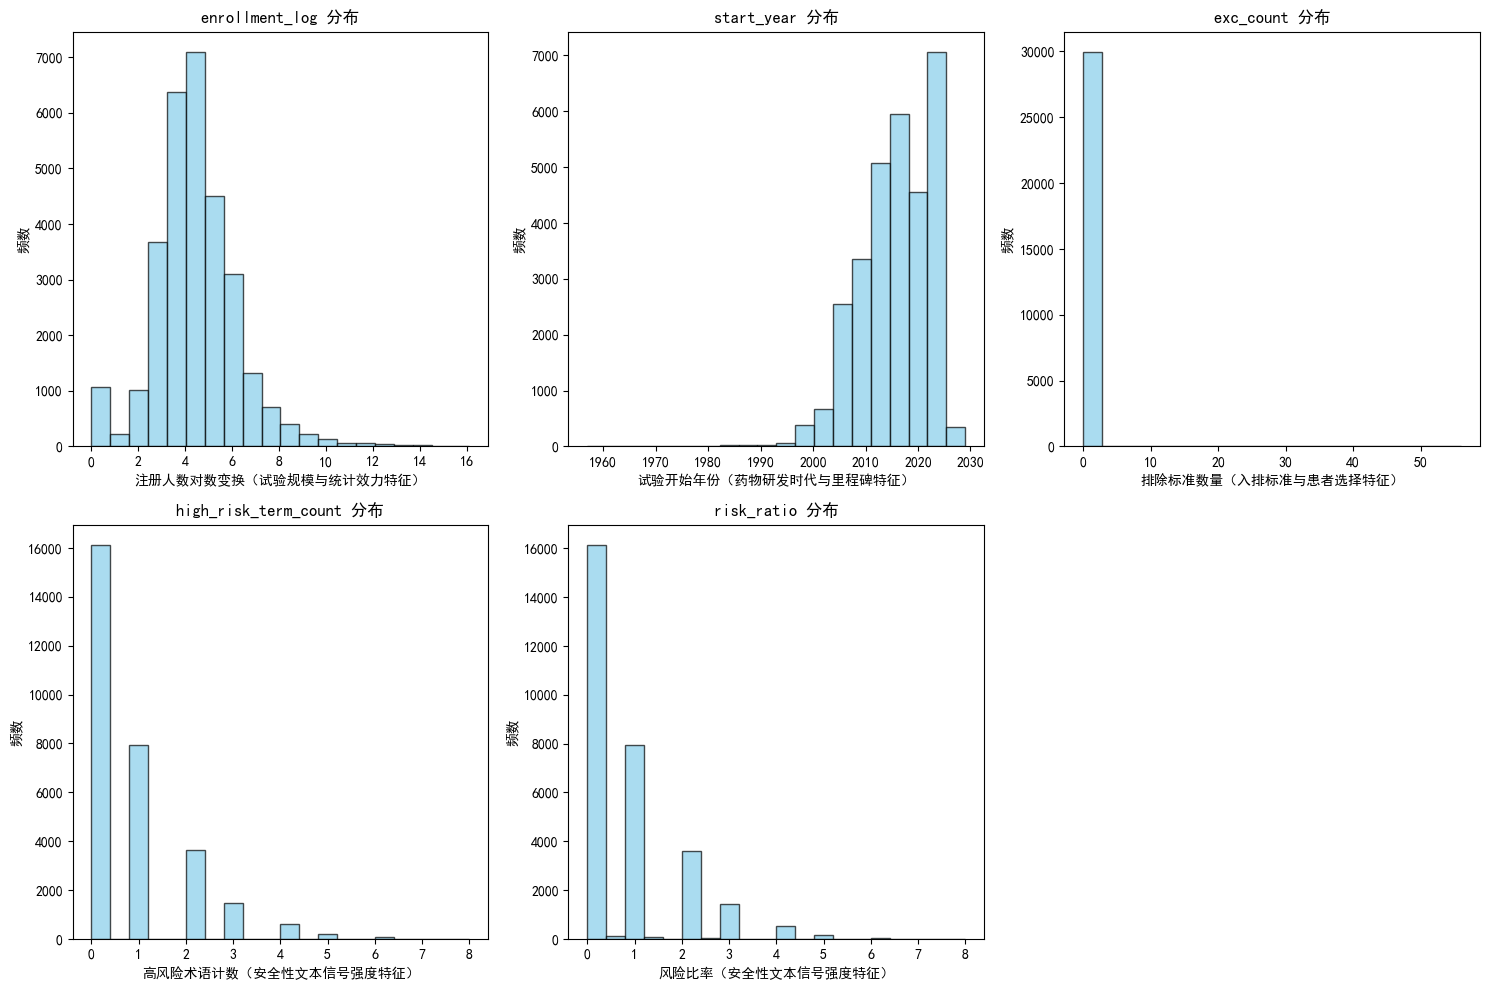

✅ 特征可视化完成

📝 总结：
   - 成功构建了18个临床驱动的风险预测特征
   - 特征涵盖了试验规模、时代背景、阶段、适应症等多个维度
   - 所有特征已保存到文件，可供后续分析使用


In [7]:
# 可选：特征可视化
print("📊 开始特征可视化...")

# 选择几个关键特征进行可视化
key_features = ['enrollment_log', 'start_year', 'exc_count', 'high_risk_term_count', 'risk_ratio']

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        axes[i].hist(features_df[feature], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{feature} 分布', fontsize=12)
        axes[i].set_xlabel(feature_descriptions[feature])
        axes[i].set_ylabel('频数')

# 隐藏多余的子图
for i in range(len(key_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

print("✅ 特征可视化完成")
print("\n📝 总结：")
print("   - 成功构建了18个临床驱动的风险预测特征")
print("   - 特征涵盖了试验规模、时代背景、阶段、适应症等多个维度")
print("   - 所有特征已保存到文件，可供后续分析使用")